# Naiver Bayes-Klassifikator


Datengrundlage für die folgende Aufgabenstellung ist der Titanic-Datensatz, unter /Data abgelegt.

In dieser Aufgabe sollen Sie einen Klassifikator auf Basis des Bayes-Theorem's selbst implementieren. Wir nehmen für diese Aufgabe an, dass die einzelnen Merkmale unabhängig voneinander sind. Man spricht in der Literatur von einem naiven Bayes-Klassifikator. Formal lässt sich der naive Bayes-Klassifikator wie folgt beschreiben:

Gegeben sei ein Merkmalsvektor $\vec x = (x_1,\dots, x_n)$  bestehend aus $n$ Merkmalen. Des Weiteren sei $L = \{C_1,\dots,C_K\}$ die Menge von möglichen Klassen. Dann berechnet sich nach Bayes die a posteriori Wahrscheinlichkeit 

$p(C_k \vert \vec{x}) = \frac{P(C_k) \ p(\vec{x} \vert C_k)}{p(\vec{x})} \,$ mit $p(\vec x) = \sum_{k\in L} P(C_k) \ p(\vec{x} \vert C_k) .$

Nimmt man an, dass die einzenen Merkmale $x_1,\dots,x_i$ unabhängig voneinander sind, lässt sich die a posteriori Wahrscheinlichkeit wie folgt berechnen:

$p(C_k \vert x_1, \dots, x_n) = \frac{P(C_k) \prod_{i=1}^n p(x_i \vert C_k)}{p(\vec x)}$

Da $p(x)$ für ein gegebenen Merkmalsvektor $\vec x$ konstant ist, und somit die Entscheidung nicht beeinflusst, kann der naive Bayes-Klassifikator wie folgt formuliert werden:

$C_y = \operatorname{argmax}_{k \in L} P(C_k) \prod_{i=1}^n p(x_i \vert C_k)$ 


Ziel dieser Aufgabe ist einen solchen naiven Bayes-Klassifikator für die konkrete Anwendung zu implementieren. Idealerweise verwendet man dafür einen großen Datensatz. Für das Verständnis des Algorithmus erfolgt die Implementierung anhand des bereits bekannten Titanic-Datensatzes. 

###  Ziel -> 𝐶𝑦=argmax p_survived [ (p(Fare|survived))*  (p(Age|survived)) *  (p(Sex|survived)) *  (p(Pclass|survived))]

## 1.) Vorbereitungen


In [1]:
import numpy as np
import csv as csv
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import math
%matplotlib inline

DATA_FILE = './Data/original_titanic.csv'

In [2]:
df = pd.read_csv(DATA_FILE)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Home-Dest
0,1,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,2,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,3,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,4,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,5,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"


Gerne können Sie zum Füllen der Datenlücken auch Ihre Implementierung aus den vorherigen Aufgabe einsetzen...

In [3]:
def prepareData(df):
    df.loc[np.isnan(df["Age"]) & (df['Sex']=='female'), 'Age'] = df.loc[df['Sex']=='female', 'Age'].mean()
    df.loc[np.isnan(df["Age"]) & (df['Sex']=='male'), 'Age'] = df.loc[df['Sex']=='male', 'Age'].mean()
    df.loc[:,'Fare'].interpolate(method='pad', inplace= True) #using existing values to fill NaN values    

In [4]:
prepareData(df)

## 1.1) A Priori Wahrscheinlichkeiten
Bestimmen Sie die A-Priori Wahrscheinlichkeiten $P(C_{survived})$ sowie $P(C_{\neg survived})$ anhand der Stichprobe.

In [31]:
# TODO implement
survived = df['Survived'].loc[df['Survived'] == 1]
p_survived = survived.count()/len(df)
p_not_survived = 1- p_survived

print(p_survived, p_not_survived)

0.3819709702062643 0.6180290297937356


## 1.2) Klassenbedingte Wahrscheinlichkeiten (likelihood)
Ziel dieser Aufgabe ist es die klassenbedingten Wahrscheinlichkeiten $p(\vec{x} \vert C_k)$ für die Merkmale *Age, Fare, Sex und Pclass* zu bestimmen.

### Quantitative Merkmale
Im folgenden sollen die Parameter der normalverteilen Wahrscheinlichkeitsdichtefunktion (WDF) für die Merkmal *Age* und *Fare* geschätzt werden. 

Visualisieren Sie zuerst die diskrete klassenbedingte Verteilung des Merkmales *Fare*.

In [5]:
print(df.loc[:,'Fare'].isnull().sum())
print(df.loc[:,'Pclass'].isnull().sum())

0
0


<Figure size 1080x360 with 0 Axes>

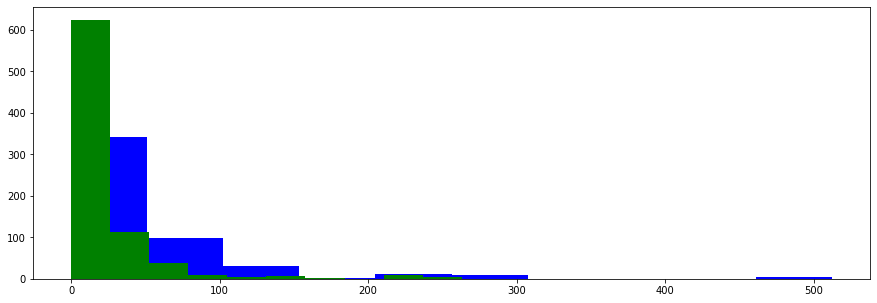

<AxesSubplot:ylabel='Density'>

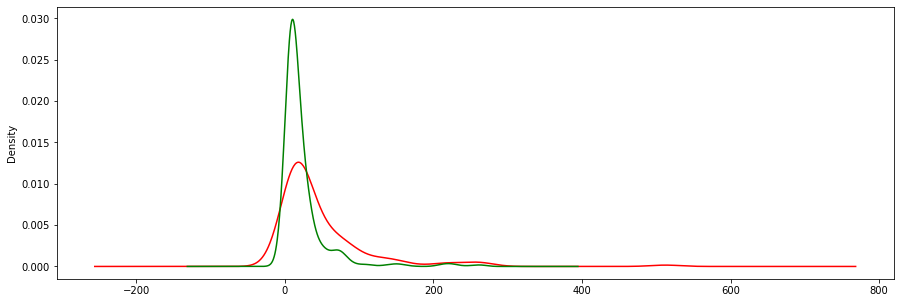

In [6]:
plt.figure(figsize=(15,5))
survived_ = df.loc[df['Survived']==1, 'Fare']
not_survived_ = df.loc[df['Survived']==0,'Fare']

plt.figure(figsize=(15,5))
plt.hist(survived_, color="blue")
plt.hist(not_survived_, color="green")
plt.show()

plt.figure(figsize=(15,5))
survived_.plot(kind='density',color="red")
not_survived_.plot(kind='density',color="green")

Schätzen Sie die Parameter der klassenbedingten Wahrscheinlichkeitsdichtefunktion $p(Fare \vert C_{survived}),p(Fare \vert C_{\neg survived})$ (Maximum-Likelihood Methode). Gehen Sie dabei von einer Normalverteilung aus. Visualisieren Sie die WDFs. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?


Dichtefunktion:$ \frac{1}{\sqrt{2\pi\sigma^2}} exp \{- \frac{(x-\mu)^2}{2\sigma^2} \} $

In [9]:
#define a generic gaussian function.
def gaussian(x, mu, sig):
    exponent = math.exp(-(math.pow(x-mu,2)/(2*sig)))
    return (1/(math.sqrt(2*math.pi)*sig))*exponent

def pFareSurvived(fare):  
    survived_ = df.loc[df['Survived']==1, 'Fare']
    survived_mean = np.mean(np.array(survived_))
    survived_var = np.var(np.array(survived_))
    return gaussian(fare,survived_mean, survived_var)

def pFareNotSurvived(fare):
    not_survived_ = df.loc[df['Survived']==0,'Fare']
    not_survived_mean = np.mean(np.array(not_survived_))
    not_survived_var = np.var(np.array(not_survived_))
    return gaussian(fare,not_survived_mean, not_survived_var)

(array([ 26.,   0.,   3.,   7.,  11.,   4.,   7.,   5., 221., 216.]),
 array([1.07772645e-14, 8.48228371e-06, 1.69645674e-05, 2.54468511e-05,
        3.39291348e-05, 4.24114185e-05, 5.08937022e-05, 5.93759859e-05,
        6.78582696e-05, 7.63405533e-05, 8.48228371e-05]),
 <BarContainer object of 10 artists>)

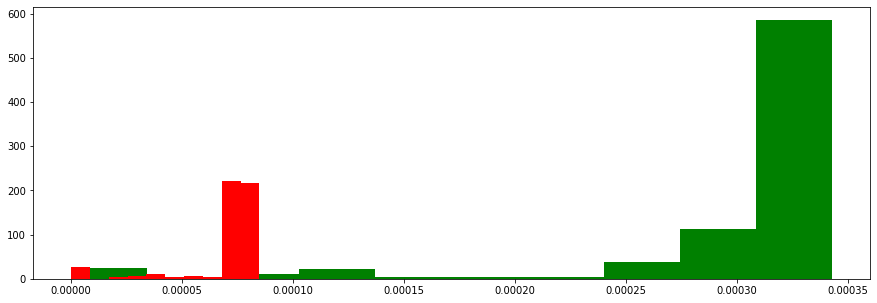

In [13]:
g_surv = []
g_not_surv = []
for x in df.loc[df['Survived']==1, 'Fare']:
    g_surv.append(pFareSurvived(x))
    
for x in df.loc[df['Survived']==0, 'Fare']:
    g_not_surv.append(pFareNotSurvived(x))
    

plt.figure(figsize=(15,5))
plt.hist(g_not_surv,color="green")
plt.hist(g_surv, color="red")

Schätzen Sie analog die Parameter der klassenbedingten Wahrscheinlichkeitsdichtefunktion $p(Age \vert C_{survived}),p(Age \vert C_{\neg survived})$ (Maximum-Likelihood Methode). Gehen Sie auch hier von einer Normalverteilung aus. Visualisieren Sie die WDFs. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?

In [14]:
def pAgeSurvived(age): 
    survived_ = df.loc[df['Survived']==1, 'Age']
    survived_mean = np.mean(np.array(survived_))
    survived_var = np.var(np.array(survived_))
    return gaussian(age,survived_mean, survived_var)
 
def pAgeNotSurvived(age):    
    not_survived_ = df.loc[df['Survived']==0,'Age']
    not_survived_mean = np.mean(np.array(not_survived_))
    not_survived_var = np.var(np.array(not_survived_))
    return gaussian(age, not_survived_mean, not_survived_var)
# TODO print und max-likelihood

(array([ 13.,  48.,  19.,  29.,   7.,  24.,  31.,  39.,  62., 228.]),
 array([2.46833607e-06, 2.08479166e-04, 4.14489996e-04, 6.20500826e-04,
        8.26511656e-04, 1.03252249e-03, 1.23853332e-03, 1.44454415e-03,
        1.65055498e-03, 1.85656580e-03, 2.06257663e-03]),
 <BarContainer object of 10 artists>)

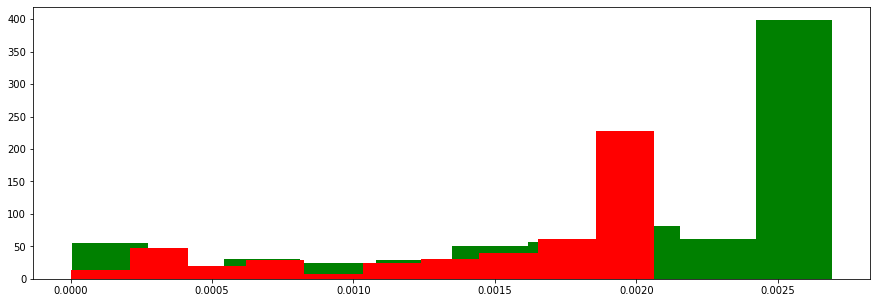

In [15]:
g_surv = []
g_not_surv = []
for x in df.loc[df['Survived']==1, 'Age']:
    g_surv.append(pAgeSurvived(x))
    
for x in df.loc[df['Survived']==0, 'Age']:
    g_not_surv.append(pAgeNotSurvived(x))
    

plt.figure(figsize=(15,5))
plt.hist(g_not_surv,color="green")
plt.hist(g_surv, color="red")

### Kategoriale Merkmale
In dem vorliegenden Datensatz sind einige kategoriale (qualitative) Merkmale enthalten. Da die klassenbedingten Wahrscheinlichkeiten für diese Merkmale nicht mit kontinuierlichen Dichtefunktionen geschätzt werden können, wird die relative Häufigkeit eingesetzt.


Visualisieren sie die absolute Häufigkeiten für das Merkmal *Pclass* für die Klassenzugehörigkeit *Survived* und *Not Survived*. 




<Figure size 1080x360 with 0 Axes>

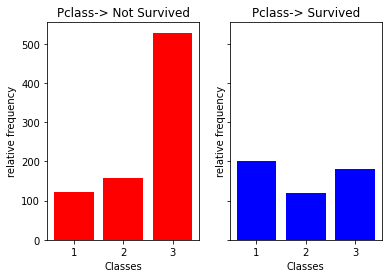

In [23]:
plt.figure(figsize=(15,5))
class_one = np.array(df.loc[df['Pclass']==1, 'Survived'])
class_two = np.array(df.loc[df['Pclass']==2, 'Survived'])
class_three = np.array(df.loc[df['Pclass']==3, 'Survived'])
classes = [1,2,3]
classes_count_survived = [len(np.where(class_one == 1)[0]),len(np.where(class_two == 1)[0]), len(np.where(class_three == 1)[0])]
classes_count_not_survived = [len(np.where(class_one == 0)[0]),len(np.where(class_two == 0)[0]), len(np.where(class_three == 0)[0])]


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.bar(classes, classes_count_not_survived, color = "red" )
ax1.set_xticks(classes)
ax1.set_xlabel("Classes")
ax1.set_ylabel("relative frequency")
ax1.set_title("Pclass-> Not Survived")

ax2.bar(classes, classes_count_survived, color= "blue" )
ax2.set_xticks(classes)
ax2.set_xlabel("Classes")
ax2.set_ylabel("relative frequency")
ax2.set_title("Pclass-> Survived")
plt.show()


Bestimmen Sie die klassenbedingten Wahrscheinlichkeiten $p(Pclass \vert C_{survived}),p(Pclass \vert C_{\neg survived})$ anhand der entsprechenden relativen Häufigkeiten und geben Sie das Ergebniss aus. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?

In [24]:
def pPClassSurvived(x):
    tmp = np.array(df.loc[df['Survived']==1, 'Pclass'])
    return len(np.where(tmp == x)[0]) / len(tmp)

def pPClassNotSurvived(x):
    tmp = np.array(df.loc[df['Survived']==0, 'Pclass'])
    return len(np.where(tmp == x)[0]) / len(tmp)

In [25]:
for pc in (1,2,3):
    print("class %d:  p(Pclass|surv): %f\tp(Pclass|notSurv): %f" % (pc,pPClassSurvived(pc),pPClassNotSurvived(pc)))

class 1:  p(Pclass|surv): 0.400000	p(Pclass|notSurv): 0.152040
class 2:  p(Pclass|surv): 0.238000	p(Pclass|notSurv): 0.195303
class 3:  p(Pclass|surv): 0.362000	p(Pclass|notSurv): 0.652658


Bestimmen sie analog die klassenbedingten Wahrscheinlichkeiten $p(Sex \vert C_{survived}),p(Sex \vert C_{\neg survived})$. Wie bewerten Sie die Trennungswirksamkeit dieses Merkmales?

In [26]:
def pSexSurvived(x):
    tmp = np.array(df.loc[df['Survived']==1, 'Sex'])
    return len(np.where(tmp == x)[0]) / len(tmp)

def pSexNotSurvived(x):
    tmp = np.array(df.loc[df['Survived']==0, 'Sex'])
    return len(np.where(tmp == x)[0]) / len(tmp)

In [27]:
for s in ("male", "female"):
    print("Sex %s:  p(Sex|surv): %f\tp(Sex|notSurv): %f" % (s,pSexSurvived(s),pSexNotSurvived(s)))

Sex male:  p(Sex|surv): 0.322000	p(Sex|notSurv): 0.843016
Sex female:  p(Sex|surv): 0.678000	p(Sex|notSurv): 0.156984


## 1.3) Klassifikator implementieren

Fügen Sie nun alle Bestandteile für den naiven Bayes-Klassifikator zusammen. Berechnen Sie zuerst die a posteriori Wahrscheinlichkeiten $p(C_k \vert x_1, \dots, x_n) = \frac{P(C_k) \prod_{i=1}^n p(x_i \vert C_k)}{p(\vec x)}$ für die beiden Klassen. Geben Sie die Ergebnisse für einen exemplarischen Merkmalsvektor $\vec x = (x_1,\dots, x_n)$ aus. 

In [106]:
#example feature vector. 
x=dict(age=25,sex='female',pclass=1,fare=100)
x

{'age': 25, 'sex': 'female', 'pclass': 1, 'fare': 100}

In [71]:
def numeratorPosteriorSurvived(x):
    return pFareSurvived(x['fare']), pAgeSurvived(x['age']),pPClassSurvived(x['pclass']), pSexSurvived(x['sex'])

def numeratorPosteriorNotSurvived(x):
    return pFareNotSurvived(x['fare']), pAgeNotSurvived(x['age']), pPClassNotSurvived(x['pclass']), pSexNotSurvived(x['sex'])

#the evidence is the dominator p(x) of the posterior
def evidence(x):
    return 1.
    
def posteriorSurvived(x): 
    probabilities = 1.
    fare, age, pclass, sex = numeratorPosteriorSurvived(x)
    print(fare, age, pclass, sex)
#     probabilities *= fare
    probabilities *= age
    probabilities *= pclass 
    probabilities *= sex
    probabilities *= p_survived
    
    return probabilities/evidence(x)
                  
    
def posteriorNotSurvived(x):
    probabilities = 1.
    fare, age, pclass, sex = numeratorPosteriorNotSurvived(x)
    print(fare, age, pclass, sex)
#     probabilities *= fare
    probabilities *= age
    probabilities *= pclass 
    probabilities *= sex
    probabilities *= p_survived
    
    return probabilities/evidence(x)
                  

In [107]:
print ("p(survived|x) = %f\n" % (posteriorSurvived(x) ))
print ("p(notSurvived|x) = %f " % (posteriorNotSurvived(x)))

6.458340765840843e-05 0.001979694485632992 0.4 0.678
p(survived|x) = 0.000205

2.7421156800410567e-05 0.002432330814856773 0.15203955500618047 0.15698393077873918
p(notSurvived|x) = 0.000022 


Da $p(\vec x)$ für ein gegebenen Merkmalsvektor $\vec x$ konstant ist und somit die Entscheidung nicht beeinflusst muss $p(\vec x)$ für die finale Klassifikation nicht berechnet werden. Des weiteren wird aus nummerischen Gründen typischerweise der Logarithmus der Wahrscheinlichkeiten eingesetzt (https://en.wikipedia.org/wiki/Log_probability).

Der naive Bayes-Klassifikator läst sich somit auch wie folgt formulieren:

\begin{equation}
\begin{aligned}
C_y &= \operatorname{argmax}_{k \in L} \log{( P(C_k) \prod_{i=1}^n p(x_i \vert C_k))} \\
    &= \operatorname{argmax}_{k \in L}  \log{P(C_k)} + \sum_{i=1}^n \log{p(x_i \vert C_k)}
\end{aligned}
\end{equation}


Implementieren und testen Sie die entsprechende Entscheidungsfunktion.

In [110]:
def logPosteriorSurvived(x):      
    log_ck = math.log(p_survived)
    log_ci_cK = math.log( np.sum(numeratorPosteriorSurvived(x)) )
    return log_ck + log_ci_cK
    
def logPosteriorNotSurvived(x):   
    log_ck = math.log(p_not_survived)
    log_ci_cK = math.log( np.sum(numeratorPosteriorNotSurvived(x)) )
    return log_ck + log_ci_cK
    
def predict(x):
    log_survived = logPosteriorSurvived(x)
    log_not_survived = logPosteriorNotSurvived(x)
    return np.argmax([log_not_survived, log_survived]) # reihenfolge entscheidet, weil index zurückgegeben wird

In [108]:
predict(x)

0

Wenden Sie den von Ihnen implementierten Algorithmus auf den Datensatz an und ermitteln Sie die Korrektklassifizierungsrate.

In [112]:
labels_true = []
labels_pred = []
tp = 0
fp = 0
tn = 0
fn = 0
for idx, row_vals in enumerate(df.loc[:, ['Age', 'Fare', 'Pclass', 'Sex', 'Survived']].values):

    labels_true.append(row_vals[-1])
    x = dict(age=row_vals[0],sex=row_vals[2],pclass=row_vals[2],fare=row_vals[1])
    y =predict(x)
    #print(idx, y)
    labels_pred.append(y)
    

for idx, label in enumerate(labels_true):
    if label == labels_pred[idx]:
        if label == 1:
             tp += 1
        else:
            tn += 1
    else:
        if label == 1:
            fn += 1          
        else:
            fp += 1
print("True Positives: %d" %tp)   
print("True Negatives: %d" %tn)

print("False Positives: %d" %fp)
print("False Negatives: %d" %fn)

if (tp + tn + fp + fn) > 0:
    acc = (tp + tn) / (tp + tn + fp + fn)
    print("Accurency: %f" %acc) 

True Positives: 200
True Negatives: 686
False Positives: 123
False Negatives: 300
Accurency: 0.676853
